In [1]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
from PcmPy.tmp__inference_cka import fit_CKA_individ, fit_CKA_group_crossval
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Load Data

Number of subjects: 24


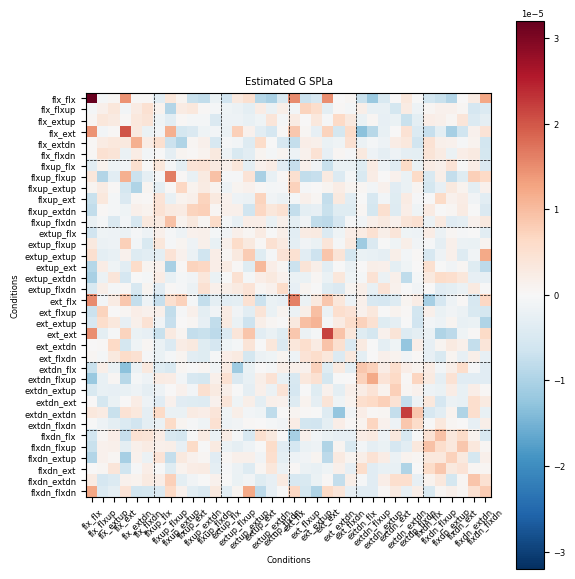

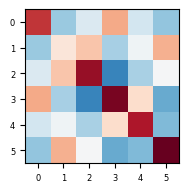

In [2]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'SPLa'

labels = ['flx_flx',    'flx_flxup',   'flx_extup',   'flx_ext',   'flx_extdn',   'flx_flxdn',
          'flxup_flx',  'flxup_flxup', 'flxup_extup', 'flxup_ext', 'flxup_extdn', 'flxup_flxdn',
          'extup_flx',  'extup_flxup', 'extup_extup', 'extup_ext', 'extup_extdn', 'extup_flxdn',
          'ext_flx',    'ext_flxup',   'ext_extup',   'ext_ext',   'ext_extdn',   'ext_flxdn',
          'extdn_flx',  'extdn_flxup', 'extdn_extup', 'extdn_ext', 'extdn_extdn', 'extdn_flxdn',
          'flxdn_flx',  'flxdn_flxup', 'flxdn_extup', 'flxdn_ext', 'flxdn_extdn', 'flxdn_flxdn']
cmap = 'RdBu_r'
ncond = 36

# load dataset:
file_path_save = os.path.join(analysisDir, f'pcm_dataset_bimanual_{region}.npz')
D = np.load(file_path_save, allow_pickle=True)
D = D['Y'].tolist()

# data g matrix:
N = len(D)
print(f'Number of subjects: {N}')
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

# plot every single G:
# for i in range(N):
#     plt.rcParams.update({'font.size': 6})
#     # visualize the estimated G:
#     G_i = G_hat[i]
#     plt.figure(figsize=(6,6))
#     vmin = -np.max(np.abs(G_i))
#     vmax = np.max(np.abs(G_i))
#     plt.imshow(G_i, cmap='RdBu_r', vmin=vmin, vmax=vmax)
#     # draw lines every 6 conitions:
#     for i in range(1,6):
#         plt.axhline(y=i*6-0.5, color='black', linestyle='--', linewidth=0.5)
#         plt.axvline(x=i*6-0.5, color='black', linestyle='--', linewidth=0.5)
#     plt.colorbar()
#     plt.title(f'Subject {i+1} Estimated G {region}')
#     plt.xlabel('Conditions')
#     plt.ylabel('Conditions')
#     plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
#     plt.yticks(ticks=np.arange(ncond), labels=labels)
#     plt.tight_layout()
#     plt.show()

plt.rcParams.update({'font.size': 6})
# visualize the estimated G:
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(6,6))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)

# draw lines every 6 conitions:
for i in range(1,6):
    plt.axhline(y=i*6-0.5, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(x=i*6-0.5, color='black', linestyle='--', linewidth=0.5)

plt.colorbar()
plt.title(f'Estimated G {region}')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

# pick every 6by6 block from G_mean:
# [0:6,0:6], [0:6,6:12], ..., [6:12,0:6], [6:12,6:12], ...
# fig, axes = plt.subplots(6,6,figsize=(12,12))
mean_tmp = np.zeros((6,6))
for i in range(0,6):
    for j in range(0,6):
        tmp = np.zeros((6,6))
        tmp = G_mean[i*6:(i+1)*6, j*6:(j+1)*6]
        tmp = pcm.centering(6) @ tmp @ pcm.centering(6)
        # ax = axes[i,j]
        # vmin = -np.max(np.abs(tmp))
        # vmax = np.max(np.abs(tmp))
        # ax.imshow(tmp, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        mean_tmp+= tmp/36
# plt.show()

plt.figure(figsize=(2,2))
vmin = -np.max(np.abs(mean_tmp))
vmax = np.max(np.abs(mean_tmp))
plt.imshow(mean_tmp, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.show()



# equal contra-ipsi weight testing

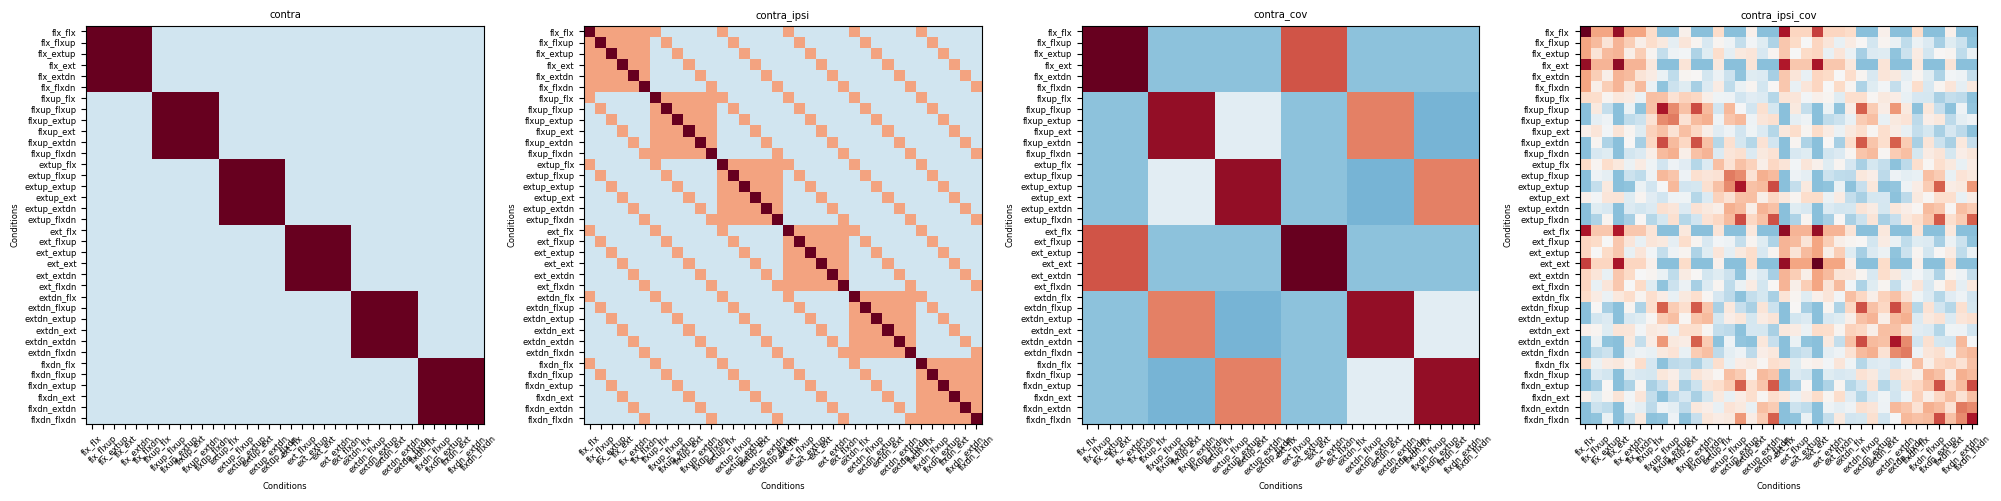

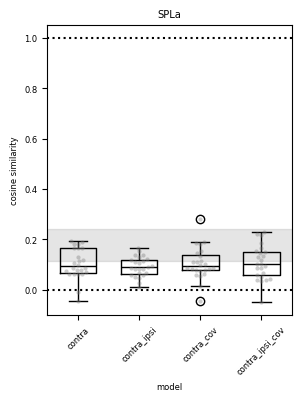

T-test contra_cov != contra: t = 0.292, p = 0.7731
T-test contra_ipsi != contra: t = -1.514, p = 0.1437
T-test contra_ipsi_cov != contra_cov: t = 0.377, p = 0.7095


In [3]:
# make feature design matrices
F_contra = np.zeros((36,6))
F_ipsi = np.zeros((36,6))
cnd2idx = {'flx':0, 'flxup':1, 'extup':2, 'ext':3, 'extdn':4, 'flxdn':5}
for i in range(36):
    cond_pair = labels[i].split('_')
    cnd_contra = cond_pair[0]
    cnd_ipsi = cond_pair[1]
    idx_contra = cnd2idx[cnd_contra]
    idx_ipsi = cnd2idx[cnd_ipsi]
    F_contra[i, idx_contra] = 1
    F_ipsi[i, idx_ipsi] = 1
# center the features:
F_contra -= np.mean(F_contra, axis=0)
F_ipsi -= np.mean(F_ipsi, axis=0)

# load region's 12by12 best model:
file_path_save = os.path.join(analysisDir, f'pcm_Ghat_best_unimanual_model_{region}.npz')
Gu = np.load(file_path_save)['G_hat']

keys = ['contra', 'contra_ipsi', 'contra_cov', 'contra_ipsi_cov']
G = []
# only contralateral:
F1 = np.concatenate((F_contra, np.zeros((36,6))), axis=1)
G1 = F1 @ F1.T
G.append(G1)

# contralateral + ipsi:
F2 = np.concatenate((F_contra, F_ipsi), axis=1)
G3 = F2 @ F2.T
G.append(G3)

# only contralateral with covariance:
F3 = np.concatenate((F_contra, np.zeros((36,6))), axis=1)
G2 = F3 @ Gu @ F3.T
G.append(G2)

# contralateral + ipsi, with covariance
F4 = np.concatenate((F_contra, F_ipsi), axis=1)
G4 = F4 @ Gu @ F4.T
G.append(G4)

# plot Gs:
plt.rcParams.update({'font.size': 6})
fig, axs = plt.subplots(1, len(G), figsize=(20,10))
for i in range(len(G)):
    g = G[i]
    ax = axs[i]
    vmin = -np.max(np.abs(g))
    vmax = np.max(np.abs(g))
    im = ax.imshow(g, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.set_title(f'{keys[i]}')
    ax.set_xlabel('Conditions')
    ax.set_ylabel('Conditions')
    ax.set_xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
    ax.set_yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

# compute CKA noise ceiling of G_hat:
N = len(D)
ceil = {'ceil_low': np.zeros((N,)), 'ceil_high': np.zeros((N,))}
df = {'model': [], 'cka': []}
for s in range(N):
    # high ceiling:
    ceil['ceil_high'][s] = pcm.util.CKA(G_hat[s,:,:], G_mean)

    # low ceiling:
    notS = np.arange(N) != s
    G_loo = np.mean(G_hat[notS,:,:], axis=0)
    ceil['ceil_low'][s] = pcm.util.CKA(G_loo, G_hat[s,:,:])

    # compute CKA for each model:
    for i_model in range(len(G)):
        cka_model = pcm.util.CKA(G[i_model], G_hat[s,:,:])
        df['model'].append(keys[i_model])
        df['cka'].append(cka_model)
df = pd.DataFrame(df)
ceil_high = np.mean(ceil['ceil_high'])
ceil_low = np.mean(ceil['ceil_low'])

# plot:
fig, ax = plt.subplots(figsize=(3,4))
sns.boxplot(data=df, x='model', y='cka', color='k', fill=False, width=0.6, linewidth=1, order=['contra', 'contra_ipsi', 'contra_cov', 'contra_ipsi_cov'], ax=ax)
sns.swarmplot(data=df, x='model', y='cka', size=3, color='gray', alpha=0.4, ax=ax)
plt.axhline(y=1, color='black', linestyle=':')
plt.axhline(y=0, color='black', linestyle=':')
plt.axhspan(ceil_low, ceil_high, color='gray', alpha=0.2, label='Ceiling')
plt.xticks(rotation=45)
plt.ylabel('cosine similarity')
plt.title(f'{region}')
plt.tight_layout()
plt.ylim((-0.1, 1.05))
plt.show()
ax.set_title(f'{region}')

# t-test m2 > m1:
m1 = 'contra'
m2 = 'contra_cov'
cka_m1 = df[df['model'] == m1]['cka']
cka_m2 = df[df['model'] == m2]['cka']
t_stat, p_val = stats.ttest_rel(cka_m2, cka_m1, alternative='two-sided')
print(f'T-test {m2} != {m1}: t = {t_stat:.3f}, p = {p_val:.4f}')

m1 = 'contra'
m2 = 'contra_ipsi'
cka_m1 = df[df['model'] == m1]['cka']
cka_m2 = df[df['model'] == m2]['cka']
t_stat, p_val = stats.ttest_rel(cka_m2, cka_m1, alternative='two-sided')
print(f'T-test {m2} != {m1}: t = {t_stat:.3f}, p = {p_val:.4f}')

m1 = 'contra_cov'
m2 = 'contra_ipsi_cov'
cka_m1 = df[df['model'] == m1]['cka']
cka_m2 = df[df['model'] == m2]['cka']
t_stat, p_val = stats.ttest_rel(cka_m2, cka_m1, alternative='two-sided')
print(f'T-test {m2} != {m1}: t = {t_stat:.3f}, p = {p_val:.4f}')




# PCM feature model

In [4]:
# make feature design matrices
F_contra = np.zeros((36,6))
F_ipsi = np.zeros((36,6))
cnd2idx = {'flx':0, 'flxup':1, 'extup':2, 'ext':3, 'extdn':4, 'flxdn':5}
for i in range(36):
    cond_pair = labels[i].split('_')
    cnd_contra = cond_pair[0]
    cnd_ipsi = cond_pair[1]
    idx_contra = cnd2idx[cnd_contra]
    idx_ipsi = cnd2idx[cnd_ipsi]
    F_contra[i, idx_contra] = 1
    F_ipsi[i, idx_ipsi] = 1
# center the features:
F_contra -= np.mean(F_contra, axis=0)
F_ipsi -= np.mean(F_ipsi, axis=0)

# load region's 12by12 best model:
file_path_save = os.path.join(analysisDir, f'best_unimanual_model_{region}.npz')
Gu = np.load(file_path_save)['G_hat']
Gu = pcm.util.make_pd(Gu)

M = []

# Only Ipsi with cov:
F1 = np.concatenate((F_contra, np.zeros_like(F_ipsi)), axis=1)
F2 = np.concatenate((np.zeros_like(F_contra), F_ipsi), axis=1)
L = np.linalg.cholesky(Gu)
A = np.stack([np.zeros_like(F1)@L,F2@L], axis=0)
M.append(pcm.model.FeatureModel('ipsi_cov', A))

# expanded eye:
cov1 = np.kron(np.eye(6), np.ones((6, 6)))/ncond
M.append(pcm.model.ComponentModel('eye', [cov1]))

# expanded rr:
cov2 = np.zeros((6,6))
cov2[0,3] = 1
cov2[3,0] = 1
# cov2 = np.tile(np.eye(6//2), (2,2)) - np.eye(6)
cov2 = np.kron(cov2, np.ones((6, 6)))/ncond
M.append(pcm.model.ComponentModel('rr', [cov1,cov2]))

# Only Contra with cov:
L = np.linalg.cholesky(Gu)
A = np.stack([F1@L,np.zeros_like(F2)@L], axis=0)
M.append(pcm.model.FeatureModel('con_cov', A))

# contra + ipsi with cov:
L = np.linalg.cholesky(Gu)
A = np.stack([F1@L,F2@L], axis=0)
M.append(pcm.model.FeatureModel('con+ipsi_cov', A))

T_ind, theta_ind, AIC = fit_CKA_individ(D, M, verbose=False, AIC=True)
T_cv, theta_cv, ceil = fit_CKA_group_crossval(D, M, verbose=False, ceil=True)



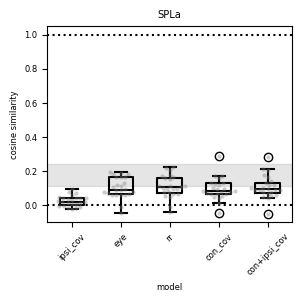

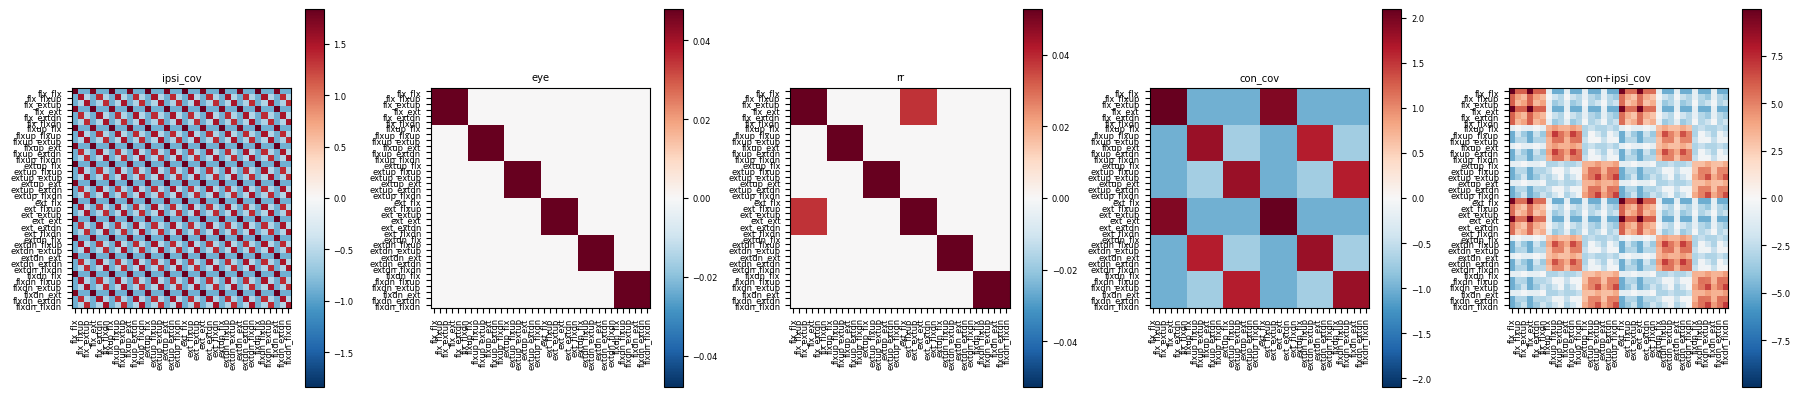

T-test con_cov > eye: t = -1.008, p = 0.8381
T-test con+ipsi_cov > con_cov: t = 2.175, p = 0.0201
T-test rr > eye: t = 1.673, p = 0.0539


In [5]:
cmap = 'RdBu_r'

# Convert MultiIndex columns to long form
# Stack the *model* level, so models become rows
T_long = (
    T_cv.stack(level='model', future_stack=True)        # move model into the index
      .reset_index()              # index -> columns
      .melt(id_vars=['level_0', 'model'],
            var_name='metric',
            value_name='value')
)
T_long

T = T_long[T_long['metric'] == 'CKA'].copy()
ceil_high = np.mean(ceil['ceil_high'])
ceil_low = np.mean(ceil['ceil_low'])
plt.figure(figsize=(3,3))
sns.boxplot(data=T, x='model', y='value', color='k', fill=False, width=0.5)
sns.swarmplot(data=T, x='model', y='value', color='gray', size=3, alpha=0.4)
plt.axhline(y=1, color='black', linestyle=':')
# make a zone for ceiling:
plt.axhspan(ceil_low, ceil_high, color='gray', alpha=0.2, label='Ceiling')
plt.xticks(rotation=45)
plt.ylabel('cosine similarity')
plt.title(f'{region}')
plt.axhline(y=0, color='black', linestyle=':')
plt.tight_layout()
plt.ylim((-0.1, 1.05))
plt.show()

nmodels = len(M)
fig, ax = plt.subplots(1, nmodels, figsize=(18,4))
th = []
for m in range(nmodels):
    th_tmp = np.exp(theta_cv[m])
    th_tmp = np.median(th_tmp, axis=1)
    th_tmp = np.log(th_tmp)
    th.append(th_tmp)
    
    G_pred = M[m].predict(th[m][:M[m].n_param])[0]
    vmin = -np.max(np.abs(G_pred))
    vmax = np.max(np.abs(G_pred))
    ax[m].imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax[m].set_xticks(list(range(ncond)))
    ax[m].set_xticklabels(labels, rotation=90)
    ax[m].set_yticks(list(range(ncond)))
    ax[m].set_yticklabels(labels)
    ax[m].set_title(f'{M[m].name}')
    plt.colorbar(ax[m].imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax[m])
plt.tight_layout()
plt.show()

# t-test CKA models m2[i] > m1[i]:
m1 = ['eye','con_cov','eye']
m2 = ['con_cov','con+ipsi_cov','rr']
for i in range(len(m1)):
    cka_m1 = T[T['model'] == m1[i]]['value'].values
    cka_m2 = T[T['model'] == m2[i]]['value'].values
    t_stat, p_val = stats.ttest_rel(cka_m2, cka_m1, alternative='greater')
    print(f'T-test {m2[i]} > {m1[i]}: t = {t_stat:.3f}, p = {p_val:.4f}')
    



# PCM component model

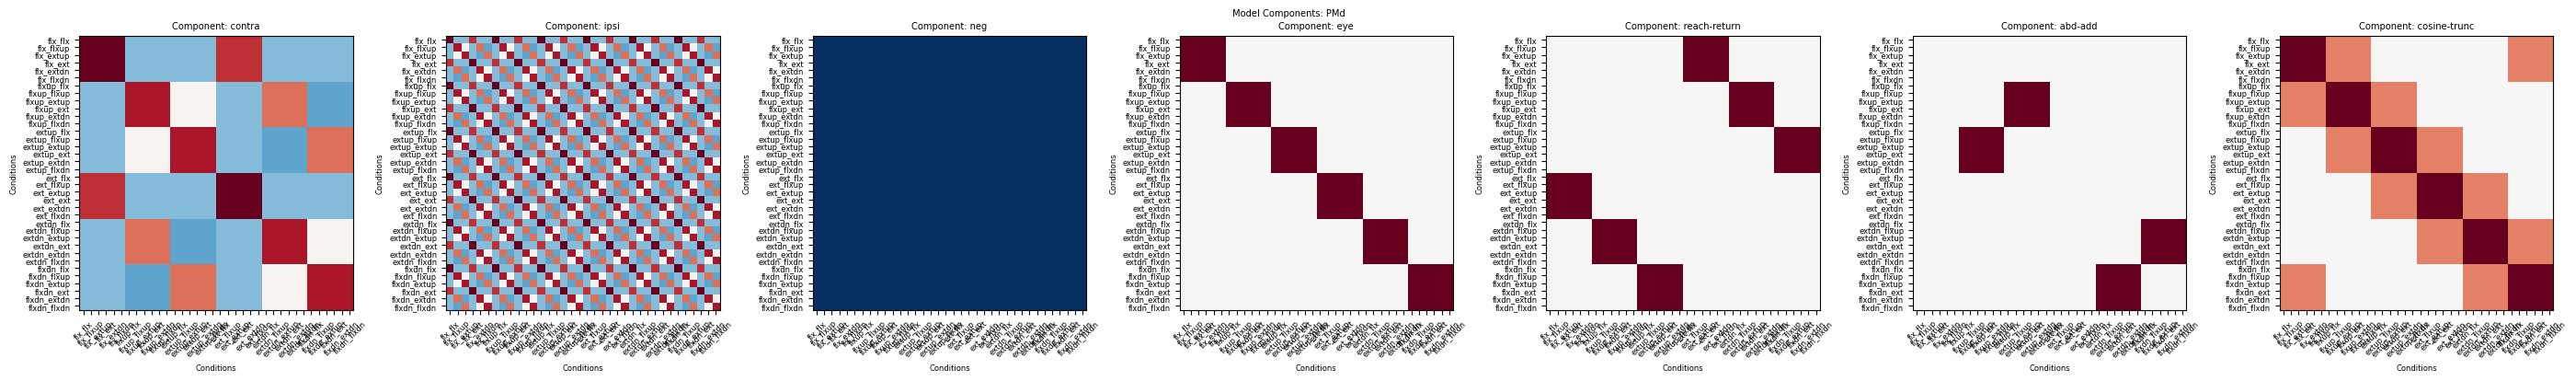

In [11]:
ncond = 36
G_model = {}

# make feature design matrices
F_contra = np.zeros((ncond,6))
F_ipsi = np.zeros((ncond,6))
cnd2idx = {'flx':0, 'flxup':1, 'extup':2, 'ext':3, 'extdn':4, 'flxdn':5}
for i in range(ncond):
    cond_pair = labels[i].split('_')
    cnd_contra = cond_pair[0]
    cnd_ipsi = cond_pair[1]
    idx_contra = cnd2idx[cnd_contra]
    idx_ipsi = cnd2idx[cnd_ipsi]
    F_contra[i, idx_contra] = 1
    F_ipsi[i, idx_ipsi] = 1
# center the features:
F_contra -= np.mean(F_contra, axis=0)
F_ipsi -= np.mean(F_ipsi, axis=0)

# load region's 12by12 best model:
file_path_save = os.path.join(analysisDir, f'best_unimanual_model_{region}.npz')
Gu = np.load(file_path_save)['G_hat']

F1 = np.concatenate((F_contra, np.zeros_like(F_ipsi)), axis=1)
G_contra = F1 @ Gu @ F1.T
G_model['contra'] = G_contra

F2 = np.concatenate((np.zeros_like(F_contra), F_ipsi), axis=1)
G_ipsi = F2 @ Gu @ F2.T
G_model['ipsi'] = G_ipsi

# all negative:
cov = -np.ones((ncond, ncond))/ncond
G_model['neg'] = cov

# expanded eye:
cov = np.kron(np.eye(6), np.ones((6, 6)))/ncond
G_model['eye'] = cov

# reach-return:
cov = np.tile(np.eye(3), (2,2)) - np.eye(6)
cov = np.kron(cov, np.ones((6, 6)))/ncond
G_model['reach-return'] = cov

# abduct-adduct:
covs = np.zeros((6,6))
covs[1,2] = 1
covs[2,1] = 1
covs[4,5] = 1
covs[5,4] = 1
cov = np.kron(covs, np.ones((6, 6)))/ncond
# covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
G_model['abd-add'] = cov

# cosine-truncated:
angles_deg = np.array([0, 60, 120, 180, 240, 300], dtype=float)
delta = np.deg2rad(angles_deg[:, None] - angles_deg[None, :])
corr = np.cos(delta)
# Truncate the cosine: only positive correlations for angles <= 90 deg
# Calculate absolute angular difference in degrees, handling wrap-around
delta_deg = np.abs(angles_deg[:, None] - angles_deg[None, :])
delta_deg = np.minimum(delta_deg, 360 - delta_deg)
# Create a mask for angles > 90 degrees
mask = delta_deg > 90
corr[mask] = 0
corr = np.kron(corr, np.ones((6, 6)))/ncond
G_model['cosine-trunc'] = corr


M = []
M.append(pcm.ComponentModel('eye', [G_model['neg'],G_model['eye']]))
M.append(pcm.ComponentModel('contra', [G_model['contra']]))
M.append(pcm.ComponentModel('contra+ipsi', [G_model['contra'], G_model['ipsi']]))

# visualize model components:
ncomponent = len(G_model.keys())
fig, axes = plt.subplots(1, ncomponent, figsize=(4*ncomponent,4))
for i, key in enumerate(G_model.keys()):
    vmin = -np.max(np.abs(G_model[key]))
    vmax = np.max(np.abs(G_model[key]))
    axes[i].imshow(G_model[key], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'Component: {key}')
    axes[i].set_xlabel('Conditions')
    axes[i].set_ylabel('Conditions')
    axes[i].set_xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
    axes[i].set_yticks(ticks=np.arange(ncond), labels=labels)
plt.suptitle(f'Model Components: {region}')
plt.tight_layout()
plt.show()


T_ind, theta_ind, AIC = fit_CKA_individ(D, M, verbose=False, AIC=True)

T_cv, theta_cv, ceil = fit_CKA_group_crossval(D, M, verbose=False, ceil=True)



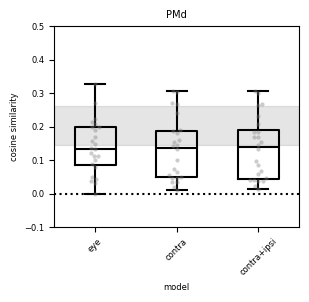

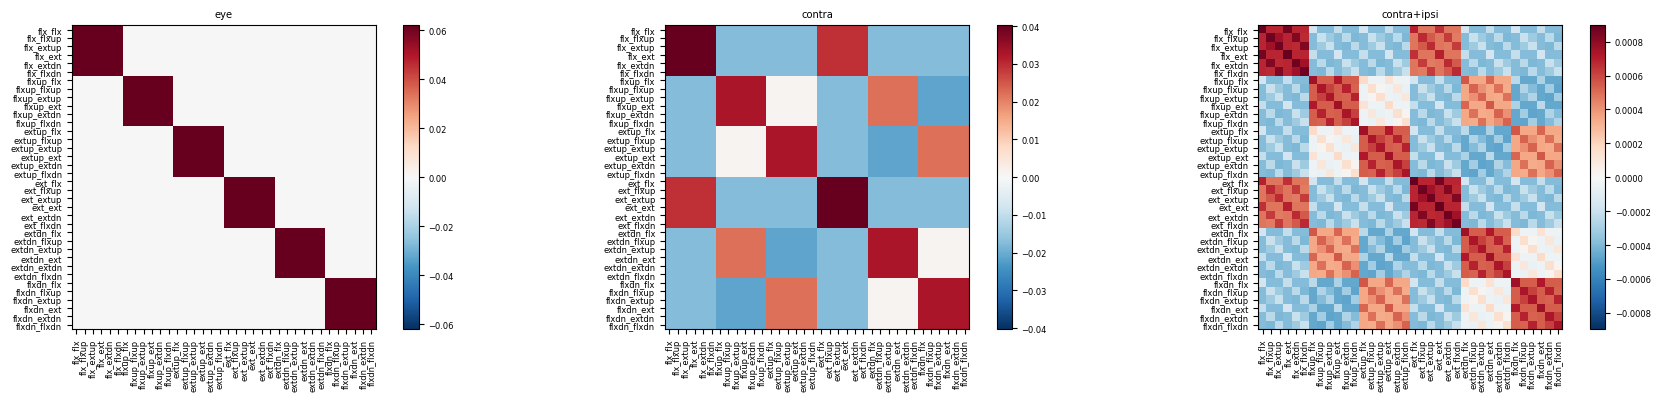

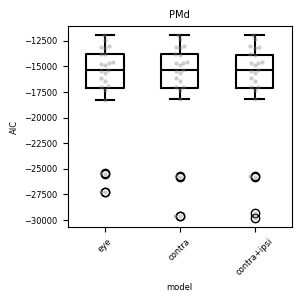

Best AIC model: contra
T-test AIC contra+ipsi < contra: t = 0.365, p = 0.6408
T-test contra+ipsi - eye: t = -0.298, p = 0.6159
T-test contra+ipsi - contra: t = 1.303, p = 0.1027


In [12]:
cmap = 'RdBu_r'

# Convert MultiIndex columns to long form
# Stack the *model* level, so models become rows
T_long = (
    T_cv.stack(level='model', future_stack=True)        # move model into the index
      .reset_index()              # index -> columns
      .melt(id_vars=['level_0', 'model'],
            var_name='metric',
            value_name='value')
)
T_long

T = T_long[T_long['metric'] == 'CKA'].copy()
ceil_high = np.mean(ceil['ceil_high'])
ceil_low = np.mean(ceil['ceil_low'])
plt.figure(figsize=(3,3))
sns.boxplot(data=T, x='model', y='value', color='k', fill=False, width=0.5)
sns.swarmplot(data=T, x='model', y='value', color='gray', size=3, alpha=0.4)
plt.axhline(y=1, color='black', linestyle=':')
# make a zone for ceiling:
plt.axhspan(ceil_low, ceil_high, color='gray', alpha=0.2, label='Ceiling')
plt.xticks(rotation=45)
plt.ylabel('cosine similarity')
plt.title(f'{region}')
plt.axhline(y=0, color='black', linestyle=':')
plt.tight_layout()
plt.ylim((-0.1, 0.5))
plt.show()

nmodels = len(M)
fig, ax = plt.subplots(1, nmodels, figsize=(18,4))
th = []
for m in range(nmodels):
    th_tmp = np.exp(theta_cv[m])
    th_tmp = np.median(th_tmp, axis=1)
    th_tmp = np.log(th_tmp)
    th.append(th_tmp)
    
    G_pred = M[m].predict(th[m][:M[m].n_param])[0]
    vmin = -np.max(np.abs(G_pred))
    vmax = np.max(np.abs(G_pred))
    ax[m].imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax[m].set_xticks(list(range(ncond)))
    ax[m].set_xticklabels(labels, rotation=90)
    ax[m].set_yticks(list(range(ncond)))
    ax[m].set_yticklabels(labels)
    ax[m].set_title(f'{M[m].name}')
    plt.colorbar(ax[m].imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax[m])
plt.tight_layout()
plt.show()

# model AICs:
AIC_flat = AIC.melt(var_name='model', value_name='AIC')
fig, ax = plt.subplots(figsize=(3,3))
sns.boxplot(data=AIC_flat, x='model', y='AIC', color='k', fill=False, width=0.5, ax=ax)
sns.swarmplot(data=AIC_flat, x='model', y='AIC', color='gray', size=3, alpha=0.4, ax=ax)
plt.xticks(rotation=45)
plt.ylabel('AIC')
plt.title(f'{region}')
plt.tight_layout()
plt.show()

# best AIC model:
aic_mean = AIC_flat.groupby('model').mean()['AIC']
best_model = aic_mean.idxmin()
print(f'Best AIC model: {best_model}')

# ttest AIC:
m1 = 'contra'
m2 = 'contra+ipsi'
aic_m1 = AIC[m1].values
aic_m2 = AIC[m2].values
t_stat, p_val = stats.ttest_rel(aic_m2, aic_m1, alternative='less')
print(f'T-test AIC {m2} < {m1}: t = {t_stat:.3f}, p = {p_val:.4f}')

# CKA t-tests:
m1 = 'eye'
m2 = 'contra+ipsi'
cka_m1 = T[T['model'] == m1]['value'].values
cka_m2 = T[T['model'] == m2]['value'].values
t_stat, p_val = stats.ttest_rel(cka_m2, cka_m1, alternative='greater')
print(f'T-test {m2} - {m1}: t = {t_stat:.3f}, p = {p_val:.4f}')

m1 = 'contra'
m2 = 'contra+ipsi'
cka_m1 = T[T['model'] == m1]['value'].values
cka_m2 = T[T['model'] == m2]['value'].values
t_stat, p_val = stats.ttest_rel(cka_m2, cka_m1, alternative='greater')
print(f'T-test {m2} - {m1}: t = {t_stat:.3f}, p = {p_val:.4f}')



# Similarity of left and right hem

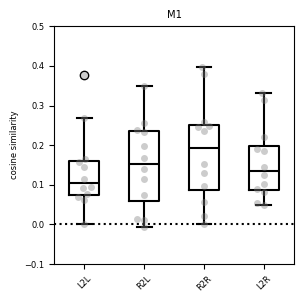

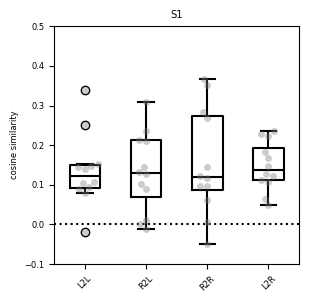

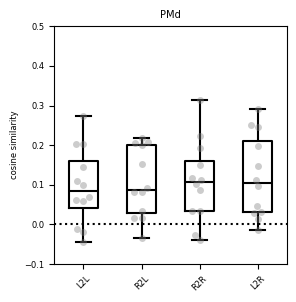

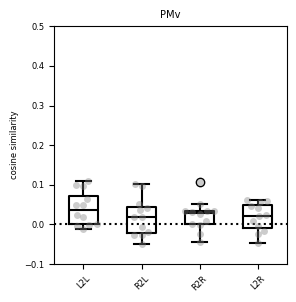

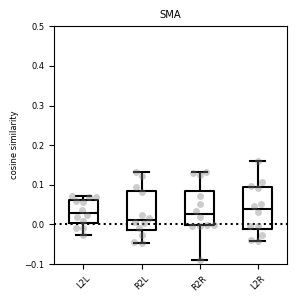

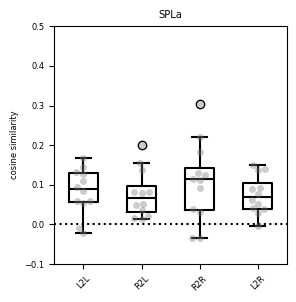

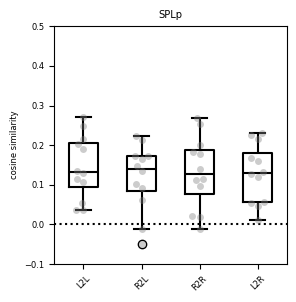

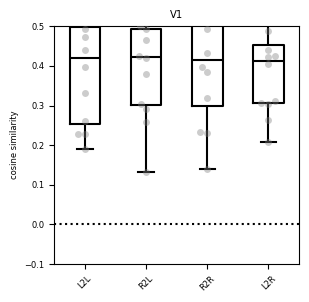

In [86]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
for region in regions:
    # load dataset:
    file_path_save = os.path.join(analysisDir, f'pcm_dataset_bimanual_{region}.npz')
    D = np.load(file_path_save, allow_pickle=True)
    D = D['Y'].tolist()

    # data g matrix:
    N = len(D)
    G_hat = np.zeros((N, ncond, ncond))
    Dist = np.zeros((N,ncond,ncond))
    for i in range(N):
        G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                                D[i].obs_descriptors['cond_vec'],
                                                D[i].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
    
    G_L = G_hat[0:12,:,:].copy()
    G_R = G_hat[12:,:,:].copy()

    cka_L2L = np.zeros((12,))
    cka_R2R = np.zeros((12,))
    cka_L2R = np.zeros((12,))
    cka_R2L = np.zeros((12,))
    for i in range(12):
        notS = np.arange(12) != i
        avg_L = np.mean(G_L[notS,:,:], axis=0)
        avg_R = np.mean(G_R[notS,:,:], axis=0)
        subj_L = G_L[i,:,:]
        subj_R = G_R[i,:,:]

        cka_L2L[i] = pcm.util.CKA(subj_L, avg_L)
        cka_R2R[i] = pcm.util.CKA(subj_R, avg_R)
        cka_L2R[i] = pcm.util.CKA(subj_L, avg_R)
        cka_R2L[i] = pcm.util.CKA(subj_R, avg_L)

    # box plot:
    fig, ax = plt.subplots(figsize=(3,3))
    data = [cka_L2L, cka_R2L, cka_R2R, cka_L2R]
    labels = ['L2L', 'R2L', 'R2R', 'L2R']
    sns.boxplot(data=data, ax=ax, color='k', fill=False, width=0.5)
    sns.swarmplot(data=data, ax=ax, color='gray', size=5, alpha=0.4)
    plt.ylabel('cosine similarity')
    plt.xticks(ticks=np.arange(4), labels=labels, rotation=45)
    plt.title(f'{region}')
    plt.tight_layout()
    plt.axhline(y=0, color='black', linestyle=':')
    plt.ylim((-0.1, 0.5))
    plt.show()




# PLOT G_est

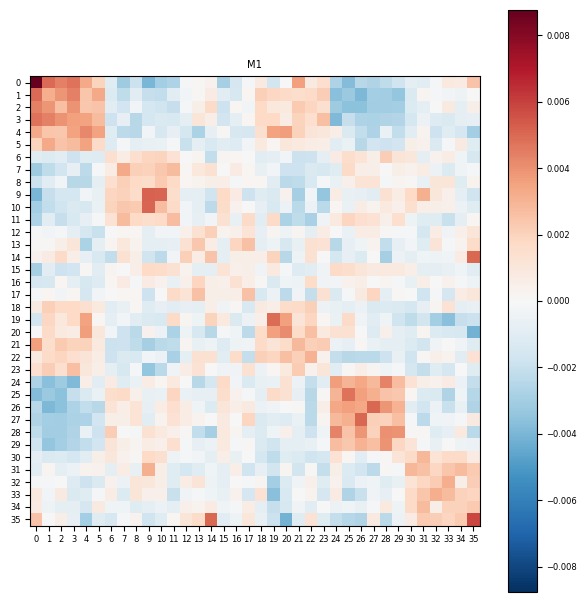

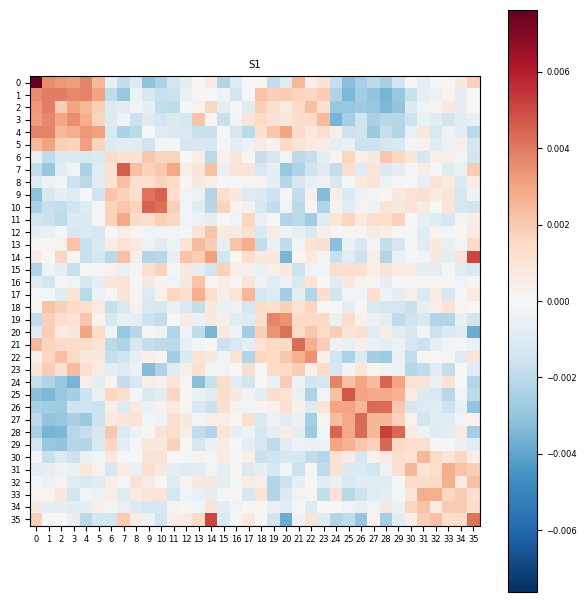

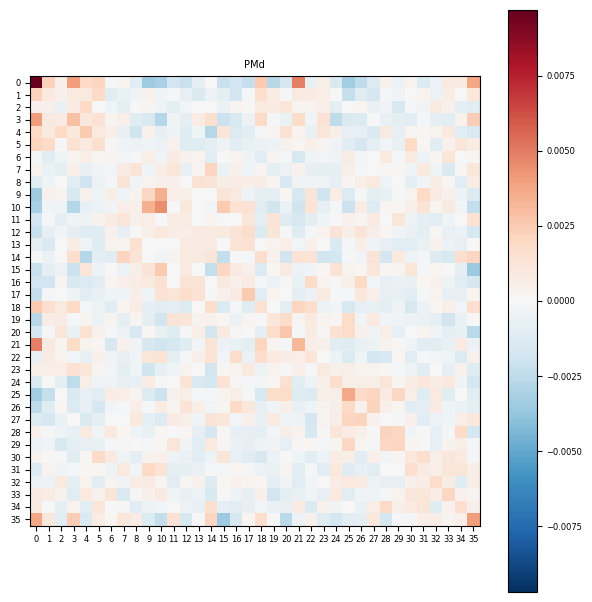

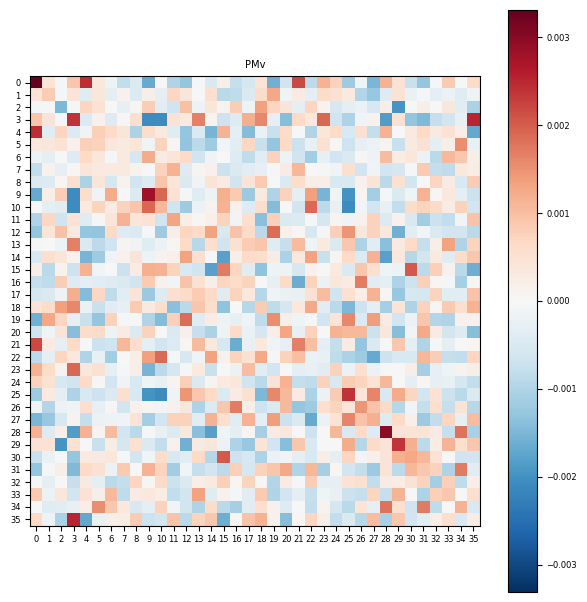

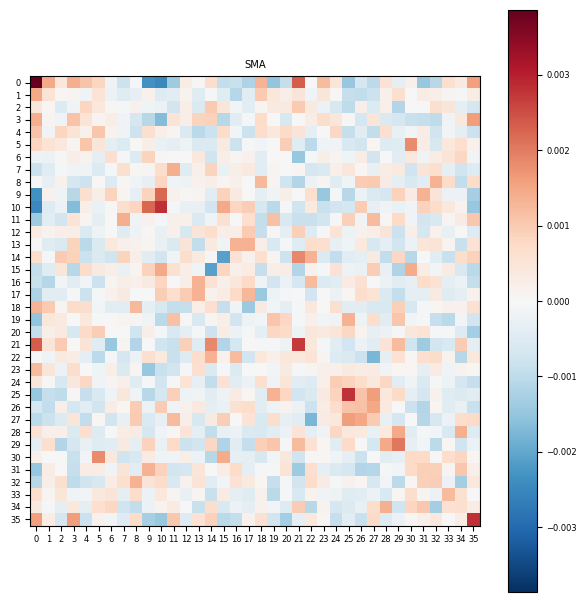

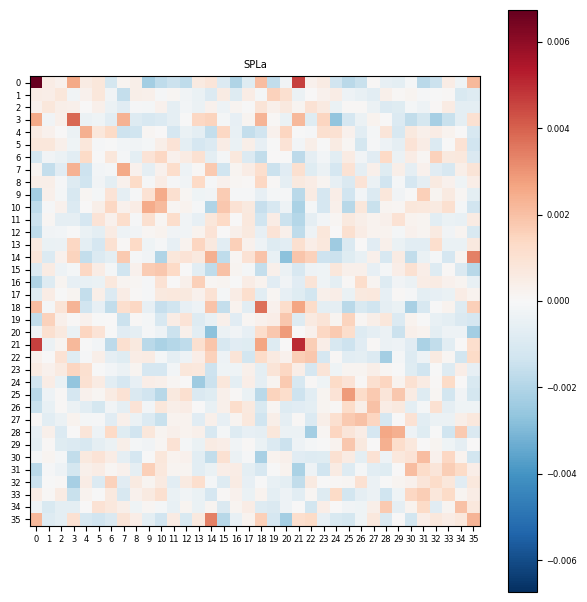

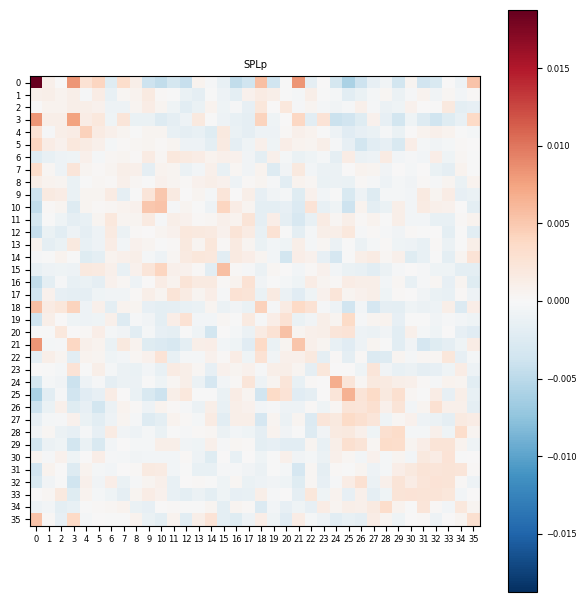

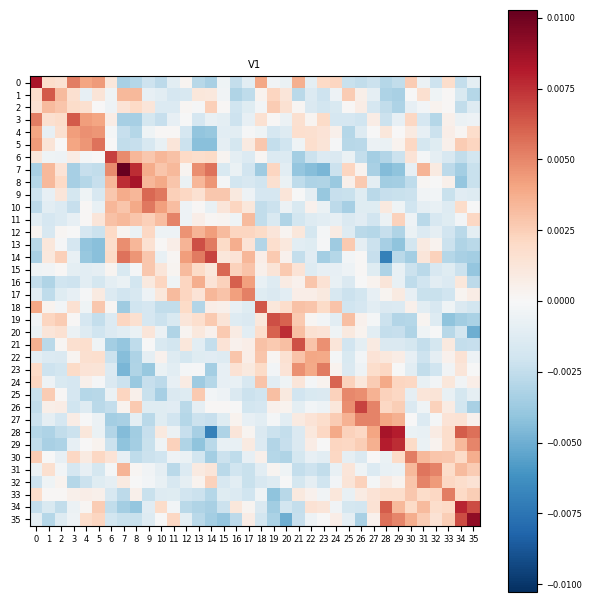

In [102]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'
cmap = 'RdBu_r'
ncond = 36

for region in regions:
    # load dataset:
    file_path_save = os.path.join(analysisDir, f'pcm_dataset_bimanual_{region}.npz')
    D = np.load(file_path_save, allow_pickle=True)
    D = D['Y'].tolist()

    # data g matrix:
    N = len(D)
    G_hat = np.zeros((N, ncond, ncond))
    for i in range(N):
        G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                                D[i].obs_descriptors['cond_vec'],
                                                D[i].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

    # PLOT:
    matplotlib.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    G_mean = np.mean(G_hat, axis=0)
    vmin = -np.max(np.abs(G_mean))
    vmax = np.max(np.abs(G_mean))
    ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.set_xticks(list(range(ncond)))
    ax.set_yticks(list(range(ncond)))
    ax.set_title(f'{region}')
    plt.colorbar(ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
    plt.tight_layout()
    plt.show()

    # fig, ax = plt.subplots(1, 1, figsize=(2,2))
    # tmp = G_mean[6:12, 6:12]
    # tmp = tmp - tmp.mean(axis=0, keepdims=True) - tmp.mean(axis=1, keepdims=True) + tmp.mean()
    # # tmp = tmp + np.ones_like(tmp)/100
    # # double center:
    # vmin = -np.max(np.abs(tmp))
    # vmax = np.max(np.abs(tmp))
    # ax.imshow(tmp, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    # ax.set_xticks(list(range(6)))
    # ax.set_yticks(list(range(6)))
    # ax.set_title(f'{region}')
    # plt.colorbar(ax.imshow(tmp, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
    # plt.tight_layout()
    # plt.show()

